# Natural Language Processing with Disaster Tweets

The goal of this project is to analyze tweets and use NLP technique to build a machine learning model and predict which tweets are talking about real disaster and which one are not

Data (link: https://www.kaggle.com/c/nlp-getting-started/overview)

## 1. Data Preprocessing

### 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Dropout
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('omw-1.4',quiet=True)

2023-05-01 15:07:57.824285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

In [2]:
train = pd.read_csv('./nlp-getting-started/train.csv')
test = pd.read_csv('./nlp-getting-started/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### 1.2 Check Missing Value

In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [7]:
# Check missing value percentage
train.isnull().mean() * 100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [8]:
test.isnull().mean() * 100

id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64

### 1.3 Deal With Missing Value

In [9]:
# Since keyword and location is likely extract from text, there are redundant as we only need text,
# we will drop these columns when we train the model later on, we don't need to deal with missing values in this case

## 2. Data Visualization

### 2.1 Histogram of Target

<AxesSubplot:xlabel='target', ylabel='Percent'>

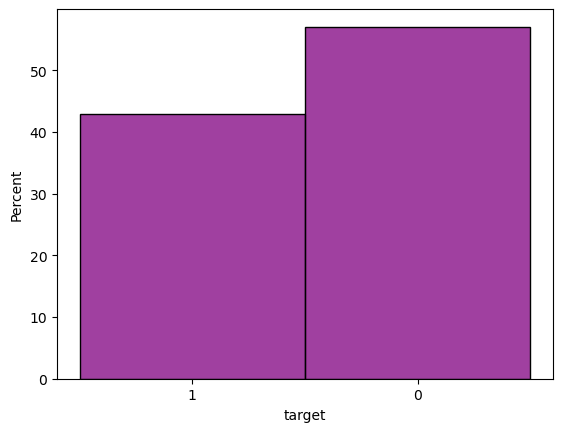

In [10]:
sns.histplot(train['target'].astype(str),stat='percent',color="purple")

Based on the plot, target of each class seems balanced

### 2.2 Top 10 Location with Most Tweets

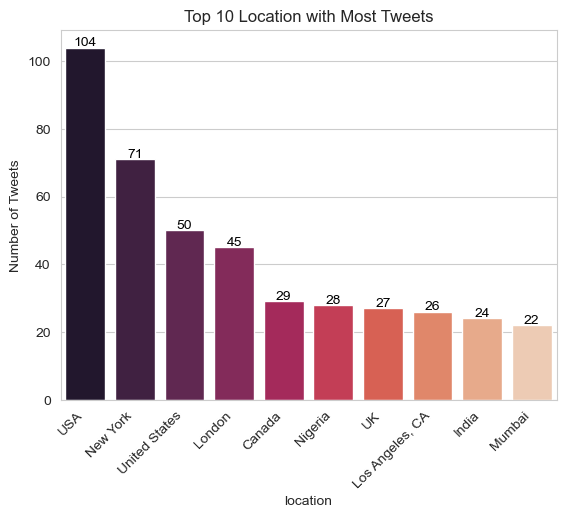

In [11]:
text_counts = train.groupby('location').count().sort_values(by='text', ascending=False).head(10)

sns.set_style('whitegrid')
sns.barplot(x=text_counts.index, y=text_counts['text'], palette='rocket')
for i, v in enumerate(text_counts['text']):
    plt.text(i, v + 0.5, str(v), color='black', ha='center')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Tweets')
plt.title('Top 10 Location with Most Tweets')
plt.show()

Based on the plot, we can see that location column is not well cleaned, but we can still tell most tweets come from US

### 2.3 Top 10 Keywords

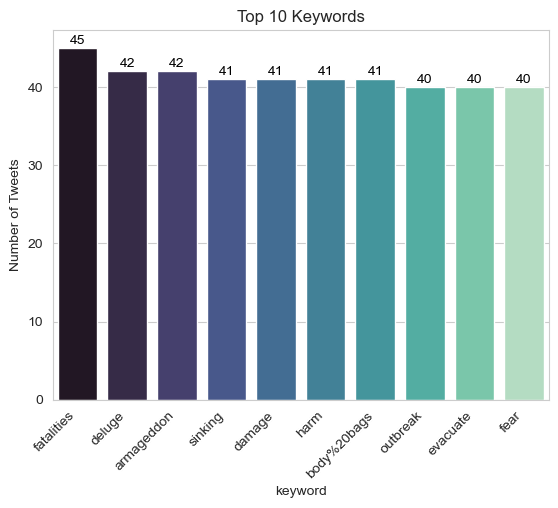

In [12]:
kw_counts = train.groupby('keyword').count().sort_values(by='text', ascending=False).head(10)

sns.barplot(x=kw_counts.index, y=kw_counts['text'], palette='mako')
for i, v in enumerate(kw_counts['text']):
    plt.text(i, v + 0.5, str(v), color='black', ha='center')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Tweets')
plt.title('Top 10 Keywords')
plt.show()

Based on the plot, we can see that top keywords are all related to disaster

## 3. Model Architecture

### 3.1 Remove Redundant Columns

In [13]:
new_train = train.drop(columns=['id','keyword','location'])
new_test = test.drop(columns=['id','keyword','location',])

### 3.2 Text Preprocessing

In [14]:
new_train['text'] = new_train['text'].astype(str)
new_test['text'] = new_test['text'].astype(str)

In [15]:
# Custom function with nltk built in function to clean up text
def clean_text(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # tokenized the text
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    # remove stop words
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    # lemmatized the token
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    cleaned_text = " ".join(lemmatized_tokens)
    return cleaned_text

In [16]:
new_train['text'] = new_train['text'].apply(clean_text)
new_test['text'] = new_test['text'].apply(clean_text)

In [17]:
# Get the frequency of each word
all_words = []
for i in new_train['text']:
    for j in i.split():
        all_words.append(j)
freq_dist = FreqDist(all_words)

### 3.3 Top 10 Common Words

<AxesSubplot:xlabel='Frequency', ylabel='Word'>

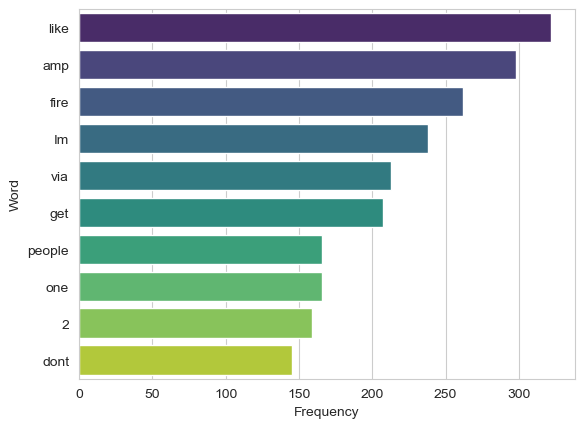

In [18]:
freq_df = pd.DataFrame(freq_dist.most_common(10), columns=['Word', 'Frequency'])
sns.barplot(x="Frequency", y="Word", data=freq_df,palette='viridis')

Can't tell much from the plot as these are just most common words that have been used

### 3.4 Convert Text To Matrix

There are many methods to process text to matrix form such as CountVectorizer,TfidfVectorizer,Word Embeddings etc
In this project, we use the Tokenizer class and pad_sequences function in keras to convert a list of texts to a matrix of fixed length sequences

In [19]:
X_train, X_val, y_train, y_val = train_test_split(new_train['text'], new_train['target'],
                                                  test_size=0.2, random_state=9)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_train['text'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(new_test['text'])

max_length = 111
X_train = pad_sequences(X_train_seq,maxlen=max_length)
X_val = pad_sequences(X_val_seq,maxlen=max_length)
X_test = pad_sequences(X_test_seq,maxlen=max_length)

### 3.5 Build LSTM  model

In [20]:
model = Sequential()
model.add(Embedding(input_dim=30000,output_dim=32, input_length=111))
model.add(LSTM(units=32, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## 4. Modeling And Evaluation

### 4.1 Train Model

In [21]:
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
191/191 [==============================] - 26s 117ms/step - loss: 0.5907 - accuracy: 0.6803 - val_loss: 0.4508 - val_accuracy: 0.7997
Epoch 2/5
191/191 [==============================] - 22s 118ms/step - loss: 0.3085 - accuracy: 0.8788 - val_loss: 0.4632 - val_accuracy: 0.7866
Epoch 3/5
191/191 [==============================] - 21s 112ms/step - loss: 0.1603 - accuracy: 0.9455 - val_loss: 0.5445 - val_accuracy: 0.7722
Epoch 4/5
191/191 [==============================] - 21s 109ms/step - loss: 0.0893 - accuracy: 0.9700 - val_loss: 0.6616 - val_accuracy: 0.7676
Epoch 5/5
191/191 [==============================] - 21s 109ms/step - loss: 0.0503 - accuracy: 0.9833 - val_loss: 0.6975 - val_accuracy: 0.7708


### 4.2 Evaluate Model

In [22]:
loss, acc = model.evaluate(X_val, y_val)
print(f'Test loss: {loss}')
print(f'Test accuracy: {acc}')

48/48 [==============================] - 1s 13ms/step - loss: 0.6975 - accuracy: 0.7708
Test loss: 0.6974847316741943
Test accuracy: 0.7708470225334167


### 4.3 Hyperparameter Tuning

1. LSTM units determines the capacity of the model to capture long-term dependencies in the input sequence. A higher number of LSTM units can lead to better performance.
2. Dropout is a regularization technique that randomly drops out a fraction of the LSTM units during training. A higher dropout rate can lead to better generalization performance

In [23]:
# Try Higher lstm_units and drop out rate
new_model = Sequential()
new_model.add(Embedding(input_dim=30000,output_dim=32, input_length=111))
new_model.add(LSTM(units=128, dropout=0.5,recurrent_dropout=0.5))
new_model.add(Dense(units=1, activation='sigmoid'))

new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
new_model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
191/191 [==============================] - 46s 223ms/step - loss: 0.5872 - accuracy: 0.6852 - val_loss: 0.4724 - val_accuracy: 0.7846
Epoch 2/5
191/191 [==============================] - 41s 217ms/step - loss: 0.3315 - accuracy: 0.8655 - val_loss: 0.4585 - val_accuracy: 0.7905
Epoch 3/5
191/191 [==============================] - 41s 213ms/step - loss: 0.1961 - accuracy: 0.9251 - val_loss: 0.5163 - val_accuracy: 0.7814
Epoch 4/5
191/191 [==============================] - 42s 218ms/step - loss: 0.1186 - accuracy: 0.9562 - val_loss: 0.5914 - val_accuracy: 0.7603
Epoch 5/5
191/191 [==============================] - 42s 220ms/step - loss: 0.0795 - accuracy: 0.9722 - val_loss: 0.6816 - val_accuracy: 0.7768


In [25]:
loss, acc = new_model.evaluate(X_val, y_val)
print(f'Test loss: {loss}')
print(f'Test accuracy: {acc}')

48/48 [==============================] - 2s 32ms/step - loss: 0.6816 - accuracy: 0.7768
Test loss: 0.6816050410270691
Test accuracy: 0.7767564058303833


### 4.4 Pick Best Model And Predict On Test

In [26]:
y_pred = new_model.predict(X_test)
my_label = np.where(y_pred > 0.5,1,0)
final_df = test
final_df['target'] = my_label
final_df = final_df[['id','target']]
final_df.to_csv('final_model.csv',index=False)

102/102 [==============================] - 3s 30ms/step


## 5. Conclusions

Overall, the model after hyperparameter tuning gives a slightly better score. This project is a good practice to get familiar with NLP, how to process text data and use other sequential deep learning model to train and predict. We can try other RNN models and do more hyperparameter tuning in the future to potential improve the model performace